In [14]:
import uhd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [15]:

usrp = uhd.usrp.MultiUSRP()

num_samps = 10000000 # number of samples received
center_freq = 2.44e9# Hz
sample_rate = 56e6 # Hz twice the BW
Fs = 56e6
gain = 0# dB
Threshhold = -60 #dB

usrp.set_rx_rate(sample_rate, 0)
usrp.set_rx_freq(uhd.libpyuhd.types.tune_request(center_freq), 0)
usrp.set_rx_gain(gain, 0)
usrp.set_rx_agc(False, 0)

In [16]:
batch = 1000
# Set up the stream and receive buffer
st_args = uhd.usrp.StreamArgs("fc32", "sc16")
st_args.channels = [0]
metadata = uhd.types.RXMetadata()
streamer = usrp.get_rx_stream(st_args)
recv_buffer = np.zeros((1, batch), dtype=np.complex64)

# Start Stream
stream_cmd = uhd.types.StreamCMD(uhd.types.StreamMode.start_cont)
stream_cmd.stream_now = True
streamer.issue_stream_cmd(stream_cmd)

In [17]:
batch = 1000
# Set up the stream and receive buffer
st_args = uhd.usrp.StreamArgs("fc32", "sc16")
st_args.channels = [0]
metadata = uhd.types.RXMetadata()
streamer = usrp.get_rx_stream(st_args)
recv_buffer = np.zeros((1, batch), dtype=np.complex64)

# Start Stream
stream_cmd = uhd.types.StreamCMD(uhd.types.StreamMode.start_cont)
stream_cmd.stream_now = True
streamer.issue_stream_cmd(stream_cmd)

In [18]:
# Receive Samples
import numpy as np

f = open("RawIQ.iq","wb")
samples = np.zeros(batch, dtype=np.complex64)
# for i in range(num_samps//batch):
i =0
x=100000
while i <1000000:

    streamer.recv(recv_buffer, metadata)
    # for i in range(len(recv_buffer)):
    #     if abs(recv_buffer[0][i])< 10**(Threshhold/10):
    #         recv_buffer[0][i] = 0
    samples = recv_buffer[0]
    # print(max(abs(samples)))
    if sum(abs(samples))/batch > 0.00:
        # print(max(abs(samples)))
        samples.tofile(f)
        i+= 1
        if(i%(x/100) == 0):
            print(i/x)
    

# Stop Stream
stream_cmd = uhd.types.StreamCMD(uhd.types.StreamMode.stop_cont)
streamer.issue_stream_cmd(stream_cmd)

# we will only take the FFT of the first 1024 samples, see text below


DOOO

0.1
0.2
0.3


OOOOO

0.4
0.5
0.6


OOOOOO

0.7
0.8
0.9
1.0


OOOOOO

1.1
1.2
1.3
1.4
1.5


OOOOOO

1.6
1.7
1.8
1.9


OOOOO

2.0
2.1
2.2


OOOO

2.3
2.4
2.5


OOOO

2.6
2.7
2.8


OOOOO

2.9
3.0
3.1
3.2


OOOOO

3.3
3.4
3.5


OOOO

3.6
3.7
3.8
3.9


OOOOOO

4.0
4.1
4.2
4.3


OOOOOO

4.4
4.5
4.6
4.7


OOOOOO

4.8
4.9
5.0
5.1
5.2


OOOOOOO

5.3
5.4
5.5


OOOO

5.6
5.7
5.8
5.9


OOOOOO

6.0
6.1
6.2
6.3
6.4


OOOOOOO

6.5
6.6
6.7
6.8


OOOOOOOOOO

6.9
7.0
7.1
7.2


OOOOOOO

7.3
7.4
7.5
7.6
7.7


OOOOOOO

7.8
7.9
8.0
8.1
8.2


OOOOOO

8.3
8.4
8.5
8.6


OOOOO

8.7
8.8
8.9
9.0
9.1


OOOOOOO

9.2
9.3
9.4
9.5


OOOOOOO

9.6
9.7
9.8
9.9
10.0


OOOOOOO

10.1
10.2
10.3
10.4
10.5


OOOOOOO

10.6
10.7
10.8
10.9
11.0


OOOOOOO

11.1
11.2
11.3
11.4
11.5


OOOOOOO

11.6
11.7
11.8
11.9
12.0


OOOOOO

12.1
12.2
12.3
12.4
12.5


OOOOOOOOOOOOO

12.6
12.7
12.8
12.9
13.0


OOOOOOO

13.1
13.2
13.3
13.4
13.5


OOOOOOO

13.6
13.7
13.8
13.9
14.0


OOOOOOO

14.1
14.2
14.3
14.4
14.5


OOOOOOO

14.6
14.7
14.8
14.9
15.0


OOOOOOO

15.1
15.2
15.3
15.4
15.5


OOOOO

15.6
15.7
15.8
15.9


OOOOO

16.0
16.1
16.2


OOOOO

16.3
16.4
16.5
16.6


OOOOOO

16.7
16.8
16.9
17.0


OOOOOOO

17.1
17.2
17.3
17.4


OOOOOO

17.5
17.6
17.7


OOOO

17.8
17.9
18.0


OOOOOO

18.1
18.2
18.3
18.4


OOOOO

18.5
18.6
18.7


OOOOO

18.8
18.9
19.0
19.1


OOOOOO

19.2
19.3
19.4
19.5


OOOO

19.6
19.7
19.8


OOOOO

19.9
20.0
20.1
20.2


OOOOO

20.3
20.4
20.5


OOOOO

20.6
20.7
20.8
20.9


OOOOOO

21.0
21.1
21.2
21.3


OOOO

21.4
21.5
21.6
21.7


OOOOO

21.8
21.9
22.0
22.1


OOOOOO

22.2
22.3
22.4
22.5
22.6


OOOOOOOOOOO

22.7
22.8
22.9


OOOOOO

23.0
23.1
23.2
23.3


OOOOO

23.4
23.5
23.6
23.7


OOOO

23.8
23.9
24.0


OOOO

24.1
24.2
24.3
24.4


OOOOOO

24.5
24.6
24.7
24.8


OOOOO

24.9
25.0
25.1
25.2


OOOOOO

25.3
25.4
25.5
25.6


OOOOO

25.7
25.8
25.9


OOOO

26.0
26.1
26.2


OOOOO

26.3
26.4
26.5


OOOO

26.6
26.7
26.8


OOOO

26.9
27.0
27.1
27.2


OOOOOO

27.3
27.4
27.5
27.6


OOOOOO

27.7
27.8
27.9
28.0


OOOOOOOOOOO

28.1
28.2
28.3
28.4


OOOOOOO

28.5
28.6
28.7
28.8
28.9


OOOOOOO

29.0
29.1
29.2
29.3
29.4


OOOO

29.5
29.6
29.7


OOOO

29.8
29.9
30.0


OOOOOO

30.1
30.2
30.3
30.4


OOOOOO

30.5
30.6
30.7
30.8
30.9


OOOOOO

31.0
31.1
31.2
31.3
31.4


OOOOOO

31.5
31.6
31.7


OOOO

31.8
31.9
32.0


OOOOO

32.1
32.2
32.3
32.4


OOOOOO

32.5
32.6
32.7
32.8


OOOOOO

32.9
33.0
33.1


OOOO

33.2
33.3
33.4


OOOOO

33.5
33.6
33.7
33.8


OOOOOO

33.9
34.0
34.1


OOOO

34.2
34.3
34.4


OOOO

34.5
34.6
34.7


OOOOO

34.8
34.9
35.0


OOOOO

35.1
35.2
35.3
35.4


OOOOOO

35.5
35.6
35.7
35.8


OOOOO

35.9
36.0
36.1
36.2


OOOOOO

36.3
36.4
36.5
36.6


OOOOOOOOO

36.7
36.8
36.9
37.0


OOOOOO

37.1
37.2
37.3
37.4


OOOO

37.5
37.6
37.7


OOOOO

37.8
37.9
38.0
38.1


OOOOO

38.2
38.3
38.4


OOOOO

38.5
38.6
38.7
38.8


OOOOOO

38.9
39.0
39.1
39.2


OOOOOO

39.3
39.4
39.5
39.6


OOOOOO

39.7
39.8
39.9
40.0


OOOOOO

40.1
40.2
40.3
40.4


OOOOOO

40.5
40.6
40.7
40.8


OOOOOO

40.9
41.0
41.1
41.2


OOOOO

41.3
41.4
41.5
41.6


OOOOOO

41.7
41.8
41.9
42.0


OOOOOO

42.1
42.2
42.3
42.4


OOOOOO

42.5
42.6
42.7
42.8


OOOOO

42.9
43.0
43.1
43.2


OOOOOO

43.3
43.4
43.5
43.6


OOOOO

43.7
43.8
43.9
44.0


OOOOOO

44.1
44.2
44.3
44.4


OOOOOO

44.5
44.6
44.7


OOOO

44.8
44.9
45.0
45.1


OOOOOO

45.2
45.3
45.4
45.5


OOOOO

45.6
45.7
45.8


OOOOO

45.9
46.0
46.1
46.2


OOOOO

46.3
46.4
46.5


OOOO

46.6
46.7
46.8
46.9


OOOOOOOOO

47.0
47.1
47.2


OOOOOO

47.3
47.4
47.5
47.6


OOOOOO

47.7
47.8
47.9
48.0
48.1


OOOOOO

48.2
48.3
48.4
48.5
48.6


OOOO

48.7
48.8


OOOO

48.9
49.0
49.1
49.2


OOOOOO

49.3
49.4
49.5


OOOO

49.6
49.7
49.8
49.9


OOOOOO

50.0
50.1
50.2


OOOO

50.3
50.4
50.5


OOOO

50.6
50.7
50.8


OOOOO

50.9
51.0
51.1


OOOO

51.2
51.3
51.4
51.5


OOOOOO

51.6
51.7
51.8
51.9
52.0


OOOOOOO

52.1
52.2
52.3
52.4
52.5


OOOOOOOOOOOOO

52.6
52.7
52.8
52.9


OOOOOOO

53.0
53.1
53.2
53.3
53.4


OOOOOOO

53.5
53.6
53.7
53.8
53.9


OOOOOO

54.0
54.1
54.2
54.3
54.4


OOOOO

54.5
54.6
54.7


OOOOO

54.8
54.9
55.0
55.1


OOOOOO

55.2
55.3
55.4
55.5


OOOOO

55.6
55.7
55.8


OOOOOO

55.9
56.0
56.1
56.2


OOOOO

56.3
56.4
56.5
56.6


OOOOOO

56.7
56.8
56.9


OOOOO

57.0
57.1
57.2
57.3


OOOOO

57.4
57.5
57.6
57.7


OOOOOO

57.8
57.9
58.0
58.1


OOOOO

58.2
58.3
58.4
58.5


OOOOOO

58.6
58.7
58.8
58.9


OOOOO

59.0
59.1
59.2
59.3
59.4


OOOOOO

59.5
59.6
59.7
59.8


OOOOOO

59.9
60.0
60.1
60.2
60.3


OOOOOOO

60.4
60.5
60.6


OOOOOOOOOO

60.7
60.8
60.9
61.0
61.1


OOOOO

61.2
61.3
61.4
61.5


OOOO

61.6
61.7
61.8


OOOO

61.9
62.0
62.1


OOOOO

62.2
62.3
62.4
62.5


OOOOO

62.6
62.7
62.8
62.9


OOOOOO

63.0
63.1
63.2
63.3


OOOOOO

63.4
63.5
63.6


OOOO

63.7
63.8
63.9


OOOOO

64.0
64.1
64.2
64.3


OOOOOO

64.4
64.5
64.6


OOOO

64.7
64.8
64.9


OOOOO

65.0
65.1
65.2
65.3


OOOOOO

65.4
65.5
65.6


OOOOO

65.7
65.8
65.9
66.0


OOOOOO

66.1
66.2
66.3
66.4


OOOO

66.5
66.6
66.7
66.8


OOOOOO

66.9
67.0
67.1
67.2


OOOOOOOOOOOO

67.3
67.4
67.5
67.6
67.7


OOOOOOO

67.8
67.9
68.0
68.1
68.2


OOOOO

68.3
68.4
68.5


OOOOOO

68.6
68.7
68.8
68.9


OOOOO

69.0
69.1
69.2
69.3


OOOOO

69.4
69.5
69.6
69.7


OOOOO

69.8
69.9
70.0
70.1


OOOOOO

70.2
70.3
70.4
70.5


OOOOO

70.6
70.7
70.8


OOOOO

70.9
71.0
71.1
71.2


OOOOOO

71.3
71.4
71.5
71.6


OOOOO

71.7
71.8
71.9


OOOOO

72.0
72.1
72.2
72.3


OOOOOO

72.4
72.5
72.6


OOOOOO

72.7
72.8
72.9
73.0
73.1


OOOOOOO

73.2
73.3
73.4
73.5
73.6


OOOOOOO

73.7
73.8
73.9
74.0
74.1


OOOOOOO

74.2
74.3
74.4
74.5


OOOOO

74.6
74.7
74.8
74.9


OOOOO

75.0
75.1
75.2


OOOO

75.3
75.4
75.5


OOOO

75.6
75.7
75.8
75.9


OOOOOOO

76.0
76.1
76.2
76.3


OOOOOO

76.4
76.5
76.6


OOOO

76.7
76.8
76.9


OOOOO

77.0
77.1
77.2
77.3


OOOOOO

77.4
77.5
77.6
77.7


OOOOOO

77.8
77.9
78.0
78.1


OOOOOO

78.2
78.3
78.4
78.5


OOOOOO

78.6
78.7
78.8
78.9


OOOOOO

79.0
79.1
79.2
79.3


OOOOOO

79.4
79.5
79.6
79.7


OOOOOO

79.8
79.9
80.0
80.1


OOOOOO

80.2
80.3
80.4
80.5


OOOOOO

80.6
80.7
80.8
80.9


OOOOOO

81.0
81.1
81.2
81.3


OOOOO

81.4
81.5
81.6
81.7


OOOOOO

81.8
81.9
82.0
82.1


OOOOOO

82.2
82.3
82.4
82.5


OOOOOO

82.6
82.7
82.8
82.9


OOOOOO

83.0
83.1
83.2
83.3


OOOOOO

83.4
83.5
83.6
83.7


OOOOOO

83.8
83.9
84.0
84.1


OOOOOO

84.2
84.3
84.4
84.5


OOOOOO

84.6
84.7
84.8
84.9


OOOOOO

85.0
85.1
85.2
85.3


OOOOOO

85.4
85.5
85.6
85.7


OOOOOO

85.8
85.9
86.0
86.1


OOOOOO

86.2
86.3
86.4
86.5


OOOOO

86.6
86.7
86.8


OOOO

86.9
87.0
87.1
87.2


OOOOOO

87.3
87.4
87.5
87.6


OOOOOO

87.7
87.8
87.9
88.0


OOOOOO

88.1
88.2
88.3
88.4


OOOOOO

88.5
88.6
88.7
88.8


OOOOOOO

88.9
89.0
89.1
89.2


OOOOOO

89.3
89.4
89.5
89.6


OOOOOO

89.7
89.8
89.9
90.0


OOOOOO

90.1
90.2
90.3
90.4


OOOOO

90.5
90.6
90.7
90.8


OOOOOO

90.9
91.0
91.1
91.2


OOOOOO

91.3
91.4
91.5
91.6


OOOOOO

91.7
91.8
91.9
92.0


OOOOOO

92.1
92.2
92.3
92.4


OOOOOO

92.5
92.6
92.7
92.8


OOOOOO

92.9
93.0
93.1
93.2


OOOOOO

93.3
93.4
93.5
93.6


OOOOOO

93.7
93.8
93.9
94.0


OOOOOO

94.1
94.2
94.3
94.4


OOOOOO

94.5
94.6
94.7
94.8


OOOOOO

94.9
95.0
95.1
95.2


OOO

95.3
95.4
95.5
95.6


OOOOO

95.7
95.8
95.9
96.0


OOOOOO

96.1
96.2
96.3


OOOOO

96.4
96.5
96.6
96.7


OOOOOO

96.8
96.9
97.0
97.1


OOOOOO

97.2
97.3
97.4
97.5


OOOOOO

97.6
97.7
97.8
97.9
98.0


OOOOOOO

98.1
98.2
98.3
98.4
98.5


OOOOOOO

98.6
98.7
98.8
98.9
99.0


OOOOOOO

99.1
99.2
99.3
99.4
99.5


OOOOOOO

99.6
99.7
99.8
99.9
100.0


OOOOOOOOOOOOOO

100.1
100.2
100.3
100.4
100.5


OOOOOOO

100.6
100.7
100.8
100.9
101.0


OOOOOOO

101.1
101.2
101.3
101.4
101.5


OOOOO

101.6
101.7
101.8


OOOOOO

101.9
102.0
102.1
102.2


OOOOOOO

102.3
102.4
102.5
102.6
102.7


OOOOOO

102.8
102.9
103.0
103.1


OOOOOOO

103.2
103.3
103.4
103.5
103.6


OOOOO

103.7
103.8
103.9
104.0


OOOOOOO

104.1
104.2
104.3
104.4
104.5


OOOO

104.6
104.7
104.8
104.9


OOOOOOO

105.0
105.1
105.2


OOOOO

105.3
105.4
105.5
105.6


OOOOOO

105.7
105.8
105.9
106.0


OOOOO

106.1
106.2
106.3
106.4
106.5


OOOOOOO

106.6
106.7
106.8
106.9


OOOOO

107.0
107.1
107.2
107.3
107.4


OOOOOO

107.5
107.6
107.7
107.8


OOOOOOOOOOO

107.9
108.0
108.1
108.2


OOOOO

108.3
108.4
108.5
108.6


OOOO

108.7
108.8
108.9


OOOOO

109.0
109.1
109.2
109.3


OOOOO

109.4
109.5
109.6
109.7


OOOOOO

109.8
109.9
110.0


OOOOO

110.1
110.2
110.3


OOOO

110.4
110.5
110.6


OOOOOO

110.7
110.8
110.9
111.0
111.1


OOOOOOO

111.2
111.3
111.4
111.5
111.6


OOOOO

111.7
111.8
111.9


OOOOO

112.0
112.1
112.2
112.3
112.4


OOOOOO

112.5
112.6
112.7


OOOOO

112.8
112.9
113.0
113.1
113.2


OOOOOOO

113.3
113.4
113.5


OOOO

113.6
113.7
113.8


OOOOOOOOO

113.9
114.0
114.1
114.2


OOOOOOO

114.3
114.4
114.5
114.6
114.7


OOOOOO

114.8
114.9
115.0
115.1


OOOOOOO

115.2
115.3
115.4
115.5
115.6


OOOOOOO

115.7
115.8
115.9
116.0
116.1


OOOOOOO

116.2
116.3
116.4
116.5
116.6


OOOOOOO

116.7
116.8
116.9
117.0
117.1


OOOOOO

117.2
117.3
117.4
117.5


OOOOOOO

117.6
117.7
117.8
117.9
118.0


OOOOOOOO

118.1
118.2
118.3
118.4
118.5


OOOOOO

118.6
118.7
118.8
118.9
119.0


OOOOOOO

119.1
119.2
119.3
119.4


OOOOO

119.5
119.6
119.7


OOOOO

119.8
119.9
120.0
120.1


OOOOOO

120.2
120.3
120.4
120.5


OOOOOO

120.6
120.7
120.8
120.9
121.0


OOOOOOO

121.1
121.2
121.3
121.4
121.5


OOOOOOOO

121.6
121.7
121.8
121.9
122.0


OOOOOOOO

122.1
122.2
122.3
122.4
122.5


OOOOOOO

122.6
122.7
122.8
122.9
123.0


OOOOOOO

123.1
123.2
123.3
123.4
123.5


OOOOOO

123.6
123.7
123.8


OOOOO

123.9
124.0
124.1
124.2


OOOOO

124.3
124.4
124.5
124.6


OOOOO

124.7
124.8
124.9
125.0
125.1


OOOOOOO

125.2
125.3
125.4
125.5
125.6


OOOOOOO

125.7
125.8
125.9
126.0
126.1


OOOOOOOOOOOOOO

126.2
126.3
126.4
126.5
126.6


OOOOOOO

126.7
126.8
126.9
127.0
127.1


OOOOOOO

127.2
127.3
127.4
127.5
127.6


OOOOOOO

127.7
127.8
127.9
128.0
128.1


OOOOOOO

128.2
128.3
128.4
128.5
128.6


OOOOOO

128.7
128.8
128.9
129.0
129.1


OOOOOOO

129.2
129.3
129.4
129.5
129.6


OOOOOOO

129.7
129.8
129.9
130.0
130.1


OOOOOO

130.2
130.3
130.4
130.5
130.6


OOOOOOO

130.7
130.8
130.9
131.0


OOOOOO

131.1
131.2
131.3
131.4
131.5


OOOOOOO

131.6
131.7
131.8
131.9
132.0


OOOOOOOO

132.1
132.2
132.3
132.4
132.5


OOOOOOOO

132.6
132.7
132.8
132.9
133.0


OOOOOOO

133.1
133.2
133.3
133.4
133.5


OOOOOOO

133.6
133.7
133.8
133.9


OOOOO

134.0
134.1
134.2


OOOO

134.3
134.4
134.5
134.6


OOOOOOO

134.7
134.8
134.9
135.0
135.1


OOOOOOO

135.2
135.3
135.4
135.5
135.6


OOOOOO

135.7
135.8
135.9
136.0


OOOOOO

136.1
136.2
136.3


OOOOO

136.4
136.5
136.6


OOOOO

136.7
136.8
136.9
137.0
137.1


OOOOOOO

137.2
137.3
137.4
137.5


OOOOO

137.6
137.7
137.8
137.9


OOOOOO

138.0
138.1
138.2
138.3
138.4


OOOOOOOOOOOOOO

138.5
138.6
138.7
138.8
138.9


OOOOO

139.0
139.1
139.2
139.3
139.4
139.5
139.6


OOOOOO

139.7
139.8
139.9
140.0
140.1


OOOOOOOOOOOOOO

140.2
140.3
140.4
140.5
140.6


OOOOOOO

140.7
140.8
140.9
141.0
141.1


OOOOOOO

141.2
141.3
141.4
141.5
141.6


OOOOOO

141.7
141.8
141.9
142.0
142.1


OOOOOOO

142.2
142.3
142.4
142.5
142.6


OOOOOOO

142.7
142.8
142.9
143.0
143.1


OOOOOOO

143.2
143.3
143.4
143.5
143.6


OOOOOO

143.7
143.8
143.9
144.0


OOOOOOO

144.1
144.2
144.3
144.4
144.5


OOOOOOO

144.6
144.7
144.8
144.9
145.0


OOOOOO

145.1
145.2
145.3
145.4
145.5


OOOOOOO

145.6
145.7
145.8
145.9
146.0


OOOOOO

146.1
146.2
146.3
146.4
146.5


OOOOOOOOO

146.6
146.7


OOOOOO

146.8
146.9
147.0
147.1


OOOO

147.2
147.3
147.4


OOOOO

147.5
147.6
147.7
147.8


OOOOOOO

147.9
148.0
148.1
148.2
148.3


OOOOOO

148.4
148.5
148.6
148.7
148.8


OOOOOOO

148.9
149.0
149.1
149.2
149.3


OOOOOO

149.4
149.5
149.6
149.7
149.8


OOOOOOO

149.9
150.0
150.1
150.2
150.3


OOOOOOOOOOOOO

150.4
150.5
150.6
150.7
150.8


OOOOOOO

150.9
151.0
151.1
151.2
151.3


OOOOOOO

151.4
151.5
151.6
151.7
151.8


OOOOOOO

151.9
152.0
152.1
152.2
152.3


OOOOOOO

152.4
152.5
152.6
152.7
152.8


OOOOO

152.9
153.0
153.1


OOOOOO

153.2
153.3
153.4
153.5


OOOOOOO

153.6
153.7
153.8
153.9
154.0


OOOOOOO

154.1
154.2
154.3
154.4
154.5


OOOOOOO

154.6
154.7
154.8
154.9


OOOOOO

155.0
155.1
155.2
155.3


OOOOOOO

155.4
155.5
155.6
155.7
155.8


OOOOOOO

155.9
156.0
156.1
156.2
156.3


OOOOOOO

156.4
156.5
156.6
156.7
156.8


OOOOO

156.9
157.0
157.1


OOOOOO

157.2
157.3
157.4
157.5
157.6


OOOOO

157.7
157.8
157.9
158.0


OOOOOOO

158.1
158.2
158.3
158.4


OOOOO

158.5
158.6
158.7
158.8


OOOOO

158.9
159.0
159.1
159.2
159.3


OOOOOOO

159.4
159.5
159.6
159.7


OOOOOO

159.8
159.9
160.0
160.1


OOOOOOOOOOO

160.2
160.3
160.4
160.5
160.6


OOOOOO

160.7
160.8
160.9
161.0
161.1


OOOOO

161.2
161.3
161.4


OOOOOO

161.5
161.6
161.7
161.8


OOOOO

161.9
162.0
162.1
162.2


OOOOO

162.3
162.4
162.5


OOOOO

162.6
162.7
162.8


OOOOOO

162.9
163.0
163.1
163.2
163.3


OOOOOO

163.4
163.5
163.6
163.7


OOOOOO

163.8
163.9
164.0
164.1
164.2


OOOOOOO

164.3
164.4
164.5
164.6
164.7


OOOOOOO

164.8
164.9
165.0
165.1
165.2


OOOOOOO

165.3
165.4
165.5
165.6
165.7


OOOOOO

165.8
165.9
166.0
166.1


OOOOO

166.2
166.3
166.4
166.5


OOOOOOOOOO

166.6
166.7
166.8
166.9


OOOO

167.0
167.1
167.2


OOOOO

167.3
167.4
167.5


OOOO

167.6
167.7
167.8


OOOOO

167.9
168.0
168.1


OOOO

168.2
168.3
168.4


OOOO

168.5
168.6
168.7


OOOO

168.8
168.9
169.0


OOOO

169.1
169.2
169.3


OOOO

169.4
169.5
169.6


OOOO

169.7
169.8
169.9


OOOO

170.0
170.1
170.2
170.3


OOOOOOOOOOO

170.4
170.5
170.6
170.7


OOOOO

170.8
170.9
171.0
171.1
171.2
171.3


OOOOO

171.4
171.5
171.6


OOOO

171.7
171.8
171.9


OOOOOOOOOOO

172.0
172.1
172.2
172.3
172.4


OOOOO

172.5
172.6
172.7
172.8


OOOOOOO

172.9
173.0
173.1
173.2
173.3


OOOOO

173.4
173.5
173.6
173.7


OOOOOOO

173.8
173.9
174.0
174.1


OOOO

174.2
174.3
174.4


OOOOOO

174.5
174.6
174.7
174.8


OOOOO

174.9
175.0
175.1


OOOOOO

175.2
175.3
175.4
175.5


OOOOOO

175.6
175.7
175.8
175.9


OOOOOO

176.0
176.1
176.2
176.3


OOOO

176.4
176.5
176.6


OOOOO

176.7
176.8
176.9


OOOOO

177.0
177.1
177.2
177.3
177.4
177.5
177.6
177.7


OOOOOOOOOOO

177.8
177.9
178.0
178.1


OOOOOO

178.2
178.3
178.4
178.5


OOOOOO

178.6
178.7
178.8
178.9


OOOO

179.0
179.1
179.2
179.3
179.4


OOOOOOO

179.5
179.6
179.7


OOOOOO

179.8
179.9
180.0
180.1
180.2


OOOOOO

180.3
180.4
180.5
180.6


OOOOOOO

180.7
180.8
180.9
181.0


OOOOO

181.1
181.2
181.3
181.4
181.5


OOOOOO

181.6
181.7
181.8
181.9


OOOOOOO

182.0
182.1
182.2
182.3


OOOOO

182.4
182.5
182.6
182.7
182.8


OOOOOOO

182.9
183.0
183.1
183.2


OOOOOO

183.3
183.4
183.5
183.6


OOOOOOOOOOOO

183.7
183.8
183.9
184.0
184.1


OOOOOO

184.2
184.3
184.4
184.5


OOOOO

184.6
184.7
184.8
184.9


OOOOOO

185.0
185.1
185.2
185.3


OOOOO

185.4
185.5
185.6
185.7


OOOOOO

185.8
185.9
186.0
186.1


OOOO

186.2
186.3
186.4


OOOOO

186.5
186.6
186.7


OOOOOO

186.8
186.9
187.0
187.1


OOOOOO

187.2
187.3
187.4
187.5
187.6


OOOOOO

187.7
187.8
187.9
188.0


OOOO

188.1
188.2
188.3
188.4


OOOOOO

188.5
188.6
188.7


OOOO

188.8
188.9
189.0
189.1


OOOOOOOOOOO

189.2
189.3
189.4
189.5
189.6
189.7
189.8
189.9


OOOOOO

190.0
190.1
190.2


OOOOO

190.3
190.4
190.5


OOOO

190.6
190.7
190.8


OOOOO

190.9
191.0
191.1


OOOOO

191.2
191.3
191.4


OOOOO

191.5
191.6
191.7


OOOO

191.8
191.9
192.0
192.1


OOOOOO

192.2
192.3
192.4
192.5
192.6


OOOOOOO

192.7
192.8
192.9
193.0


OOOOOOO

193.1
193.2


OOOOOOO

193.3
193.4
193.5
193.6
193.7


OOOOOOO

193.8
193.9
194.0
194.1
194.2


OOOOOOO

194.3
194.4
194.5
194.6
194.7


OOOOOOO

194.8
194.9
195.0
195.1
195.2


OOOOOOO

195.3
195.4
195.5
195.6
195.7


OOOOOO

195.8
195.9
196.0
196.1


OOOOOO

196.2
196.3
196.4
196.5


OOOOOOO

196.6
196.7
196.8
196.9
197.0


OOOOOOO

197.1
197.2
197.3
197.4
197.5


OOOOOOO

197.6
197.7
197.8
197.9
198.0


OOOOOOO

198.1
198.2
198.3
198.4
198.5


OOOOOOO

198.6
198.7
198.8
198.9


OOOOOO

199.0
199.1
199.2
199.3


OOOOO

199.4
199.5
199.6


OOOO

199.7
199.8
199.9


OOOOO

200.0
200.1
200.2
200.3


OOOOOO

200.4
200.5
200.6
200.7


OOOOOO

200.8
200.9
201.0
201.1


OOOOOOO

201.2
201.3
201.4
201.5


OOOO

201.6
201.7
201.8


OOOOOOO

201.9
202.0
202.1
202.2
202.3


OOOOO

202.4
202.5
202.6
202.7


OOOOOO

202.8
202.9
203.0
203.1


OOOOO

203.2
203.3
203.4
203.5


OOOOOOOO

203.6
203.7
203.8
203.9
204.0


OOOOOO

204.1
204.2
204.3
204.4


OOOOO

204.5
204.6
204.7
204.8


OOOOOOO

204.9
205.0
205.1
205.2
205.3


OOOOOOO

205.4
205.5
205.6
205.7
205.8


OOOOOO

205.9
206.0
206.1
206.2


OOOOOO

206.3
206.4
206.5
206.6
206.7


OOOOOOO

206.8
206.9
207.0
207.1


OOOOOO

207.2
207.3
207.4
207.5


OOOOOO

207.6
207.7
207.8


OOOOO

207.9
208.0
208.1


OOOO

208.2
208.3
208.4


OOOOO

208.5
208.6
208.7


OOOOO

208.8
208.9
209.0
209.1
209.2


OOOOOOO

209.3
209.4
209.5
209.6


OOOOO

209.7
209.8
209.9
210.0


OOOOO

210.1
210.2
210.3
210.4


OOOOOOO

210.5
210.6
210.7
210.8


OOOOOO

210.9
211.0
211.1
211.2


OOOOO

211.3
211.4
211.5
211.6


OOOOOO

211.7
211.8
211.9
212.0


OOOOOO

212.1
212.2
212.3
212.4


OOOOOO

212.5
212.6
212.7
212.8


OOOOO

212.9
213.0
213.1
213.2


OOOOOO

213.3
213.4
213.5


OOOOO

213.6
213.7
213.8
213.9


OOOOO

214.0
214.1
214.2
214.3


OOOOOO

214.4
214.5
214.6
214.7


OOOOOO

214.8
214.9
215.0
215.1


OOOOOO

215.2
215.3
215.4
215.5


OOOOOO

215.6
215.7


OO

KeyboardInterrupt: 

1000000
0.00025466903873108676


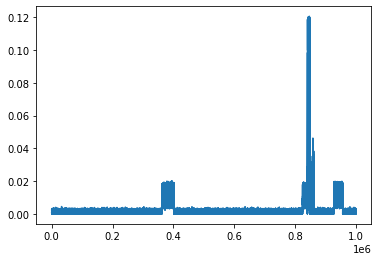

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
samples = np.fromfile('RawIQ.iq', np.complex64) # Read in file.  We have to tell it what format it is
print(len(samples))
print(sum(abs(samples))/num_samps)
# plt.figure(figsize=(10, 10), dpi=500)
# Plot constellation to make sure it looks right
plt.plot(np.abs(samples))
# # lt.grid(True)
plt.show()
plt.close()
plt.figure(figsize=(20, 20), dpi=500)
plt.plot(np.real(samples),np.imag(samples),'.')
plt.show()

